# Correlations between multiple targets for symbols

In [1]:
from itertools import combinations, chain

from math import ceil

from collections import OrderedDict as odict

import textwrap

from os import environ

import seaborn as sns

### Configuration

In [2]:
# Notebook parameters...

species = environ.get('species') or 'Human'

species

'Rat'

In [3]:
# pActivity column to use...

pactivity_col = 'pchembl_value'

In [4]:
# Minimum number of compounds in common for a pair of targets...

pair_threshold = 3

In [5]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

In [6]:
# Seaborn config...

sns.set()

### Load targets

In [7]:
# Load the ChEMBL target info...

targets = pd.read_pickle('chembl_targets.pkl').query("exclude == 0")

targets.shape

(358, 15)

In [8]:
HTML(targets.query("species == @species").head().to_html())

,symbol,approved_name,targets,n_target,chembl_id,target_type,pref_name,species,exclude,target_class_0,target_class_1,n_active_tgt,n_total_tgt,n_active_ss,n_total_ss
1,ABCB1,"ATP-binding cassette, sub-family B (MDR/TAP), member 1","MDR1;7|MDR1;8|ATP-binding cassette, sub-family B (MDR/TAP), member 1;11",1,CHEMBL1075229,SINGLE PROTEIN,Multidrug resistance protein 1,Rat,0,N/A,N/A,0,0,0,0
3,ABCB11,"ATP-binding cassette, sub-family B (MDR/TAP), member 11",BSEP;6|BSEP;7|BSEP;8,1,CHEMBL2073674,SINGLE PROTEIN,Bile salt export pump,Rat,0,N/A,N/A,8,9,8,9
5,ABCB4,"ATP-binding cassette, sub-family B (MDR/TAP), member 4",MDR3;7|MDR3;8,1,CHEMBL2073706,SINGLE PROTEIN,Multidrug resistance protein 3,Rat,0,N/A,N/A,0,0,0,0
7,ABCC2,"ATP-binding cassette, sub-family C (CFTR/MRP), member 2","MRP2;7|MRP2;8|ATP-binding cassette, sub-family C (CFTR/MRP), member 2;11",1,CHEMBL2073676,SINGLE PROTEIN,Canalicular multispecific organic anion transporter 1,Rat,0,N/A,N/A,14,55,14,55
9,ABCC3,"ATP-binding cassette, sub-family C (CFTR/MRP), member 3",MRP3;7|MRP3;8,1,CHEMBL2073682,SINGLE PROTEIN,Canalicular multispecific organic anion transporter 2,Rat,0,N/A,N/A,1,4,1,4


### Get pairs of targets for gene symbols

Pairs of targets for each symbol having more than minimm number of distinct parent compounds with pActivities associated with them.

In [9]:
# %%javascript

# IPython.notebook.kernel.execute("notebook_name = " + "'" + window.document.getElementById("notebook_name").innerHTML + "'");

notebook_name = 'Correlation_Targets' # JavaScript magic above doesn't work with runipy

In [10]:
cache_file = notebook_name + '_' + species + '.pkl'

cache_file

'Correlation_Targets_Rat.pkl'

In [11]:
# Retrieve activity data for a list of targets...

def get_data_for_targets(target_chemblids):

    sql = """
    select
        *   
    from
      tt_curve_data_v1 a
    where
      a.target_chemblid in ({})
    """.format(', '.join(":{}".format(n+1) for n in range(len(target_chemblids))))
    
    return pd.read_sql_query(sql, engine, params=target_chemblids)

In [12]:
if os.path.exists(cache_file): os.remove(cache_file)

In [13]:
# %%cache $cache_file data_by_symbol means_by_symbol pairs_by_symbol

data_by_symbol, means_by_symbol, pairs_by_symbol = odict(), odict(), odict()
    
symbols = targets.query("species == @species")[['symbol', 'chembl_id']].groupby('symbol').count().query('chembl_id > 1').reset_index()['symbol'].values.tolist()

for symbol in symbols:
    
    logging.info("Starting '{}'...".format(symbol))

    # Get list of ChEMBL targets for the gene symbol...
    
    symbol_targets = targets.query("(species == @species) & (symbol == @symbol)")

    target_chemblids = symbol_targets.chembl_id.values.tolist()

    # Get activity data for these ChEMBL targets, calculate means and unstack so each target is represented by a single column...

    data = get_data_for_targets(target_chemblids)
    
    if not data.shape[0]:
        
        logging.warn("> No data for '{}'.".format(symbol))
        
        continue

    means = data[['target_chemblid', 'parent_cmpd_chemblid', pactivity_col]].groupby(['target_chemblid', 'parent_cmpd_chemblid']).mean().unstack(level=0)

    means.columns = means.columns.droplevel()

    if means.shape[1] == 1:

        logging.warn("> Only one target with data for '{}'.".format(symbol))
        
        continue
        
    # Get all pairs of targets with a number of compounds in common greater than some threshold...
    
    try:
    
        target_pairs = pd.DataFrame(
            ((x, means[x].count(), y, means[y].count(), n, d.corr().iloc[0, 1]) for x, y, n, d in
                ((x, y, d.shape[0], d) for x, y, d in
                    ((x, y, means[[x, y]].dropna(how='any')) for x, y in
                        combinations(means.columns.values, 2)
                    )
                )
            if n > pair_threshold), 
            columns=['target_1', 'n_1', 'target_2', 'n_2', 'n', 'r']).sort(['r', 'n'], ascending=False).reset_index(drop=True)

    except ValueError as e:

        if not e.args[0].startswith('Shape of passed values is (0, 0)'): raise

        logging.warn("> No pairs of target with sufficient compounds in common for '{}'.".format(symbol))
        
        continue

    # Add full names of targets (NB renaming and reordering targets)...

    pref_names = symbol_targets[['chembl_id', 'pref_name']].reset_index(drop=True).set_index('chembl_id')

    target_pairs = target_pairs.merge(pref_names, left_on='target_1', right_index=True).merge(pref_names, left_on='target_2', right_index=True).sort('r', ascending=False)
    
    target_pairs.columns = [x.replace('_x', '_1').replace('_y', '_2') for x in target_pairs.columns.values]
    
    target_pairs = target_pairs[['target_1', 'pref_name_1', 'n_1', 'target_2', 'pref_name_2', 'n_2', 'n', 'r']]
    
    # Done...
    
    data_by_symbol[symbol], means_by_symbol[symbol], pairs_by_symbol[symbol] = data, means, target_pairs
    
    logging.info("...OK.")
    
logging.info("Finished.")

[2015/Aug/07 13:54:05 INFO    ] Starting 'CALCR'...
[2015/Aug/07 13:54:05 WARNING ] > No data for 'CALCR'.
[2015/Aug/07 13:54:05 INFO    ] Starting 'CALCRL'...
[2015/Aug/07 13:54:05 WARNING ] > Only one target with data for 'CALCRL'.
[2015/Aug/07 13:54:05 INFO    ] Starting 'CHRNA4'...
[2015/Aug/07 13:54:05 INFO    ] ...OK.
[2015/Aug/07 13:54:05 INFO    ] Starting 'GRIN1'...
[2015/Aug/07 13:54:06 INFO    ] ...OK.
[2015/Aug/07 13:54:06 INFO    ] Finished.


In [14]:
# Symbols having multiple targets with sufficient data for comparison...

[(x, y.shape[0]) for x, y in pairs_by_symbol.items()]

[('CHRNA4', 2), ('GRIN1', 5)]

In [15]:
# Show data for each symbol...

# HTML('\n'.join("<h3>{}</h3>\n{}".format(x, data_by_symbol[x].to_html()) for x in sorted(data_by_symbol.keys())))

In [16]:
# Show pair summary info for each symbol...

HTML('\n'.join("<h3>{}</h3>\n{}".format(x, pairs_by_symbol[x].to_html()) for x in sorted(pairs_by_symbol.keys())))

,target_1,pref_name_1,n_1,target_2,pref_name_2,n_2,n,r
0,CHEMBL1907596,Neuronal acetylcholine receptor; alpha4/beta2,1323,CHEMBL307,Neuronal acetylcholine receptor protein alpha-4 subunit,139,20,0.933405
1,CHEMBL1907595,Neuronal acetylcholine receptor; alpha4/beta4,161,CHEMBL1907596,Neuronal acetylcholine receptor; alpha4/beta2,1323,148,0.790306
,target_1,pref_name_1,n_1,target_2,pref_name_2,n_2,n,r
0,CHEMBL2096911,Glutamate NMDA receptor; Grin1/Grin2c,202,CHEMBL3038506,Ionotropic glutamate receptor NMDA 1/2D,41,41,0.923753
1,CHEMBL2096680,Glutamate NMDA receptor; Grin1/Grin2a,156,CHEMBL2096911,Glutamate NMDA receptor; Grin1/Grin2c,202,91,0.829275
2,CHEMBL2096666,Glutamate NMDA receptor; Grin1/Grin2b,236,CHEMBL330,Glutamate (NMDA) receptor subunit zeta 1,574,12,0.764632
3,CHEMBL2096666,Glutamate NMDA receptor; Grin1/Grin2b,236,CHEMBL2096911,Glutamate NMDA receptor; Grin1/Grin2c,202,96,0.329813
4,CHEMBL2096666,Glutamate NMDA receptor; Grin1/Grin2b,236,CHEMBL2096680,Glutamate NMDA receptor; Grin1/Grin2a,156,117,0.270470


### Plot pActivity data for pairs of assays

In [17]:
# Function to plot pChEMBL values for all pairs of ChEMBL targets for a symbol...

ncol, size = 4, 12

min_xc50, max_xc50 = 3.0, 10.0

def plots_for_symbol(symbol):
    
    target_pairs, target_means = pairs_by_symbol[symbol], means_by_symbol[symbol]

    n_pairs = target_pairs.shape[0]

    nrow = int(ceil(n_pairs / ncol))

    fig, axes = plt.subplots(nrow, ncol, figsize=(size*ncol, size*nrow))
    
    fig.suptitle(symbol)
    
    if nrow > 1: axes = list(chain.from_iterable(axes))

    for ax in axes[n_pairs:]: ax.axis('off')
        
    for i, (_, rec) in enumerate(target_pairs.iterrows()):
        
        axis = axes[i]

        pair_means = target_means[[rec.target_1, rec.target_2]].dropna(how='any')

        axis.scatter(pair_means[rec.target_1], pair_means[rec.target_2])
        
        axis.set_xlim(min_xc50, max_xc50)
        axis.set_ylim(min_xc50, max_xc50)
        axis.set_aspect(1)
        
        axis.set_title("{}  ({}/{})  r = {:.2f}  [n = {}]".format(symbol, i+1, n_pairs, rec.r, rec.n))
        axis.set_xlabel("{}  [n = {}]\n{}".format(rec.target_1, rec.n_1, rec.pref_name_1))
        axis.set_ylabel("{}  [n = {}]\n{}".format(rec.target_2, rec.n_2, rec.pref_name_2))

        axis.plot((min_xc50, max_xc50), (min_xc50, max_xc50), color='r', linestyle='-', linewidth=1)
        axis.plot((5, 5), (min_xc50, max_xc50), color='m', linestyle='--', linewidth=2)
        axis.plot((min_xc50, max_xc50), (5, 5), color='m', linestyle='--', linewidth=2)

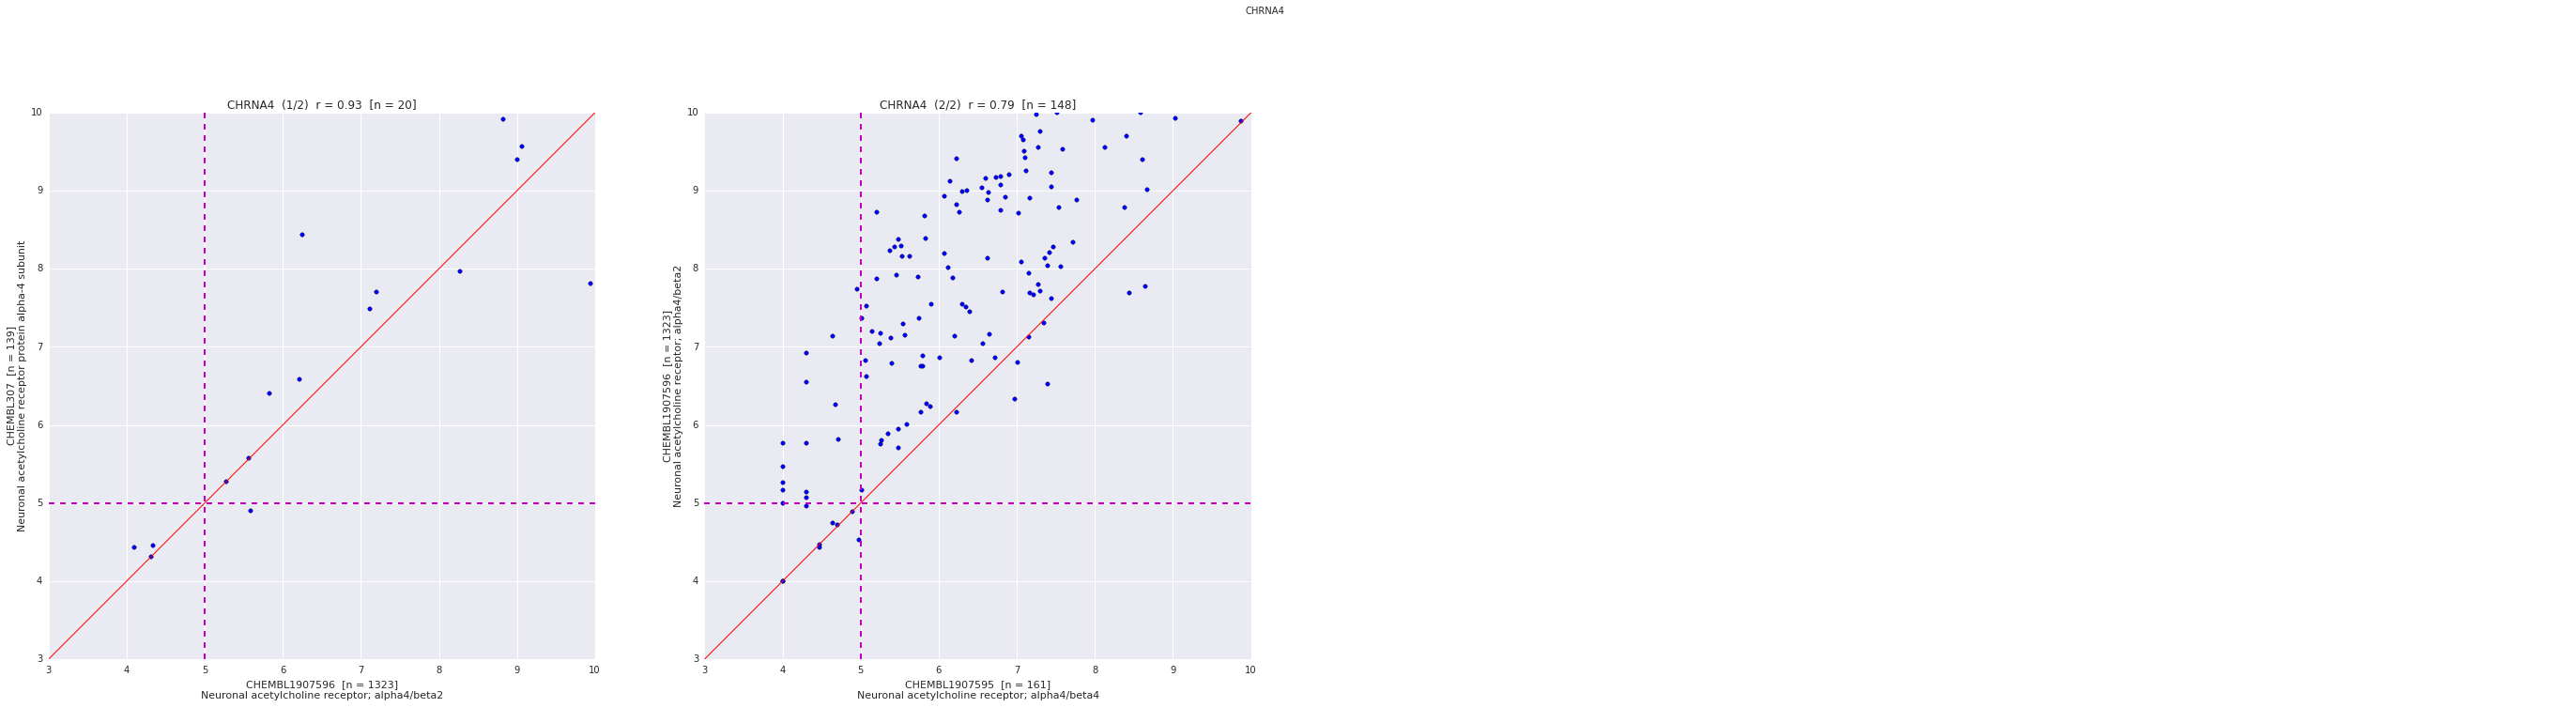

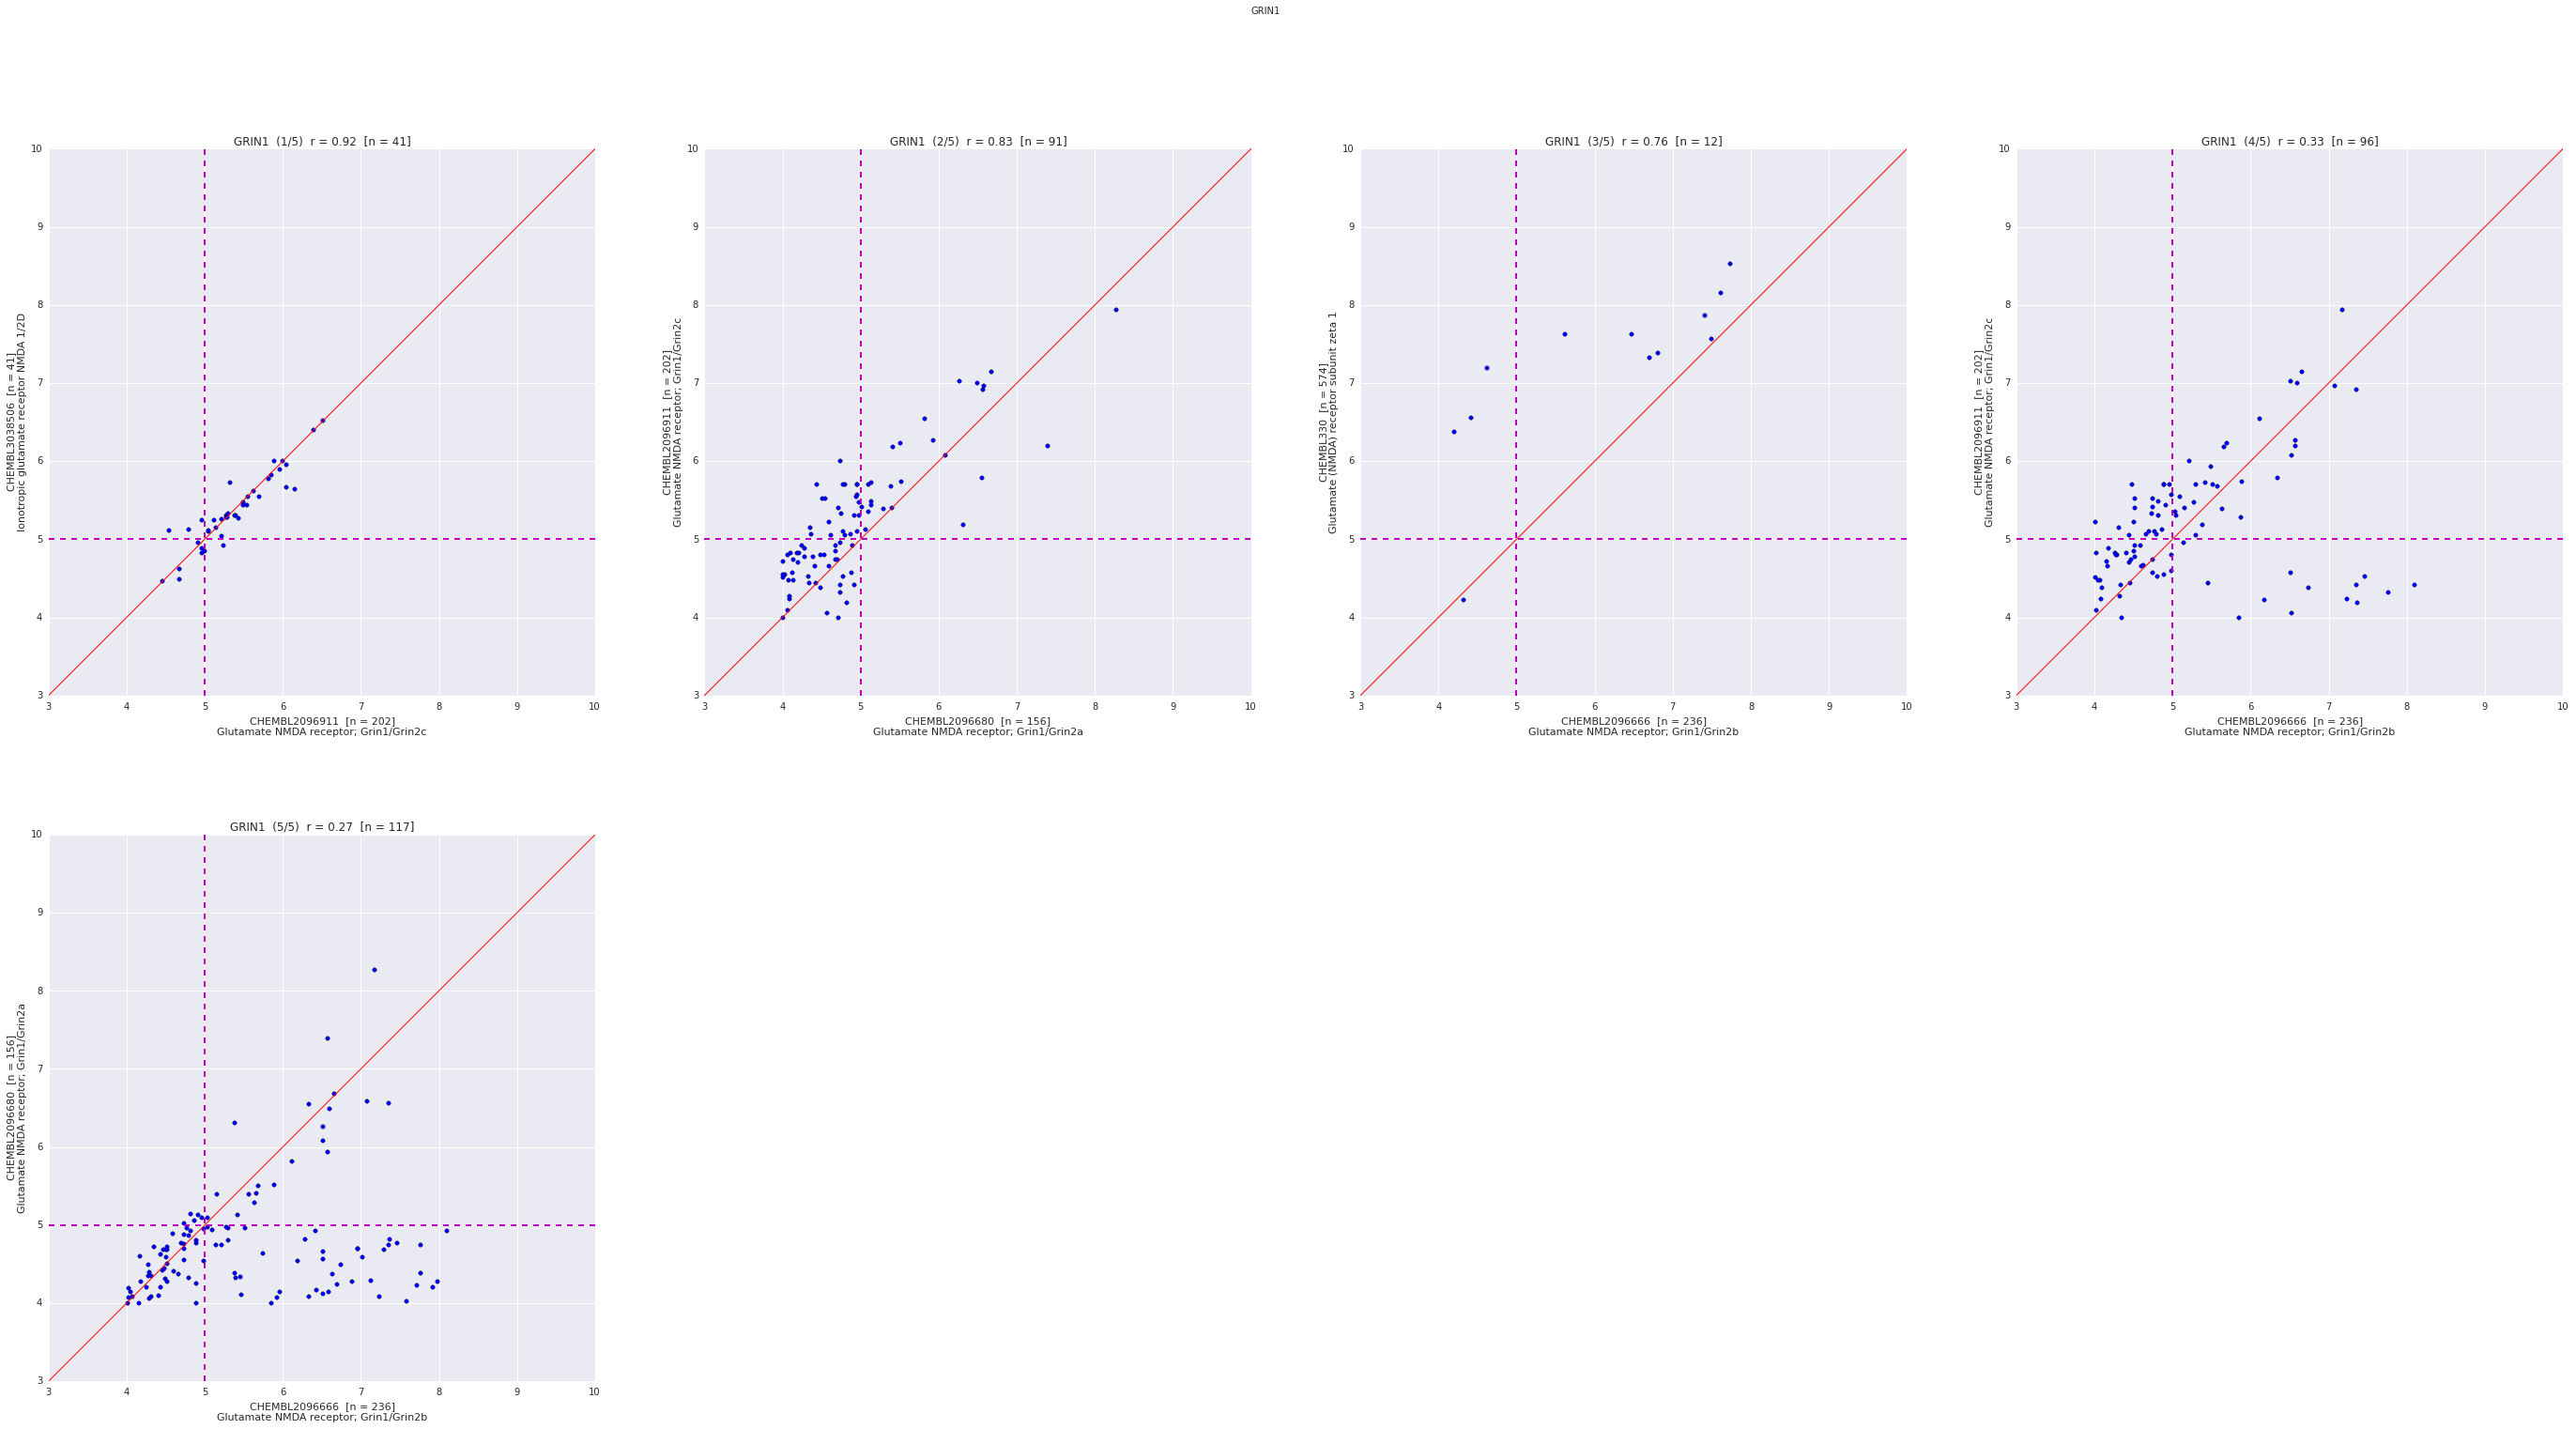

In [18]:
# Generate plots for all symbols...

for symbol in sorted(data_by_symbol.keys()):
                         
    plots_for_symbol(symbol)